In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from sklearn.manifold import TSNE

# For reproducibility
np.random.seed(42)


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select digit '8'
x_train_8 = x_train[y_train == 8]
x_test_8 = x_test[y_test == 8]

# Normalize and reshape data
x_train_8 = x_train_8.astype('float32') / 255.
x_test_8 = x_test_8.astype('float32') / 255.
x_train_8 = np.reshape(x_train_8, (len(x_train_8), 28, 28, 1))
x_test_8 = np.reshape(x_test_8, (len(x_test_8), 28, 28, 1))


In [3]:
def build_autoencoder(hidden_layers):
    input_img = Input(shape=(28, 28, 1))
    x = Flatten()(input_img)
    
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)
    
    encoded = Dense(hidden_layers[-1], activation='relu')(x)
    
    x = encoded
    for units in reversed(hidden_layers[:-1]):
        x = Dense(units, activation='relu')(x)
    
    x = Dense(28 * 28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Train autoencoder with different numbers of layers/nodes
autoencoders = {}
hidden_layer_configs = [[2], [10], [20]]

for hidden_layers in hidden_layer_configs:
    autoencoder = build_autoencoder(hidden_layers)
    autoencoder.fit(x_train_8, x_train_8, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_8, x_test_8))
    autoencoders[tuple(hidden_layers)] = autoencoder


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6911 - val_loss: 0.6840
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6752 - val_loss: 0.6136
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5674 - val_loss: 0.4200
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3840 - val_loss: 0.3022
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2935 - val_loss: 0.2671
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2661 - val_loss: 0.2566
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2555 - val_loss: 0.2521
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2537 - val_loss: 0.2494
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2502 - val_loss: 0.2479
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2489 - val_loss: 0.2464
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2467 - val_loss: 0.2455
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2461 - val_

Reconstruction with hidden layers: (2,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


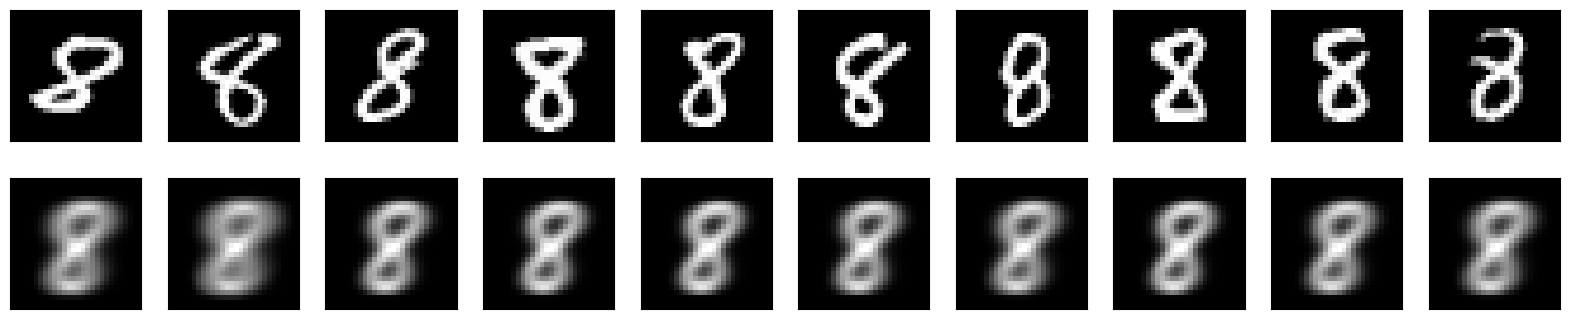

Reconstruction with hidden layers: (10,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


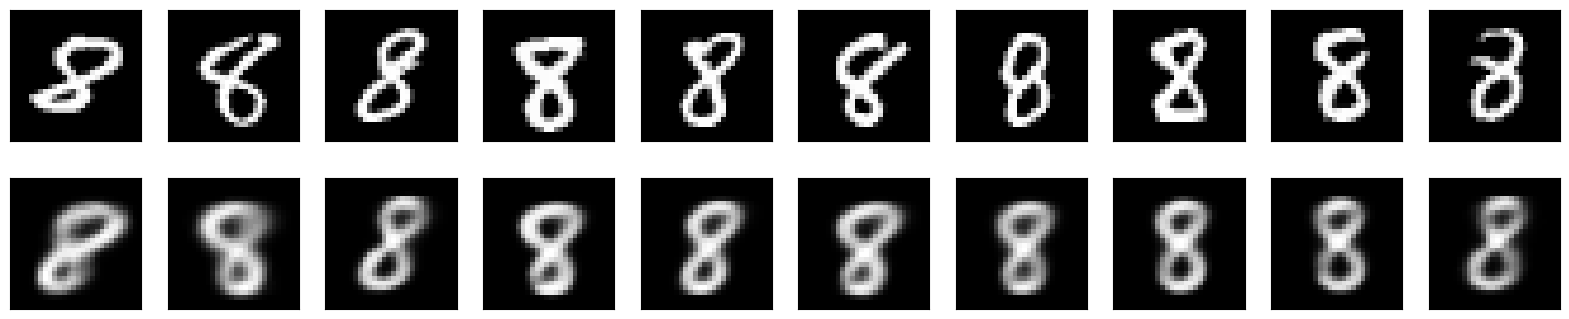

Reconstruction with hidden layers: (20,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


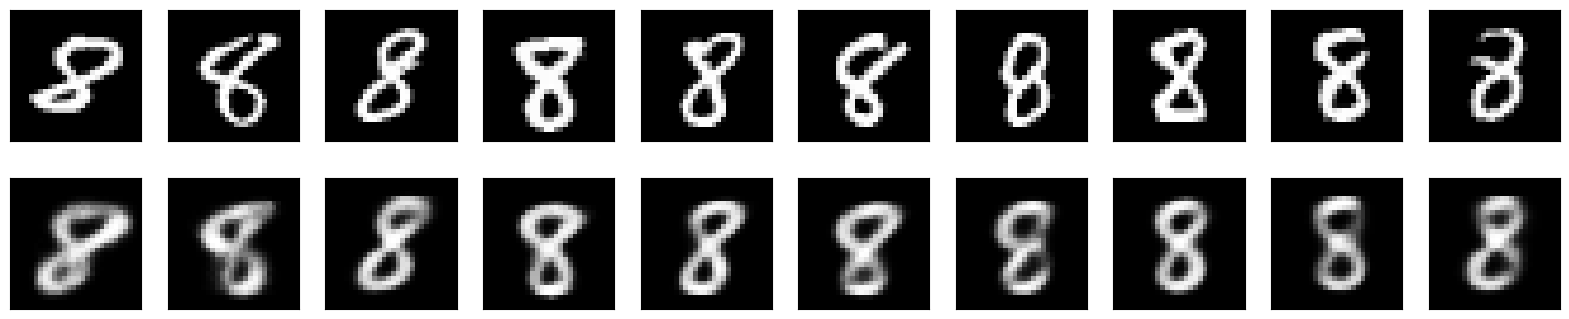

In [4]:
def visualize_reconstruction(autoencoder, x_test, n=10):
    decoded_imgs = autoencoder.predict(x_test)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

for hidden_layers, autoencoder in autoencoders.items():
    print(f"Reconstruction with hidden layers: {hidden_layers}")
    visualize_reconstruction(autoencoder, x_test_8)


Latent space visualization with hidden layers: (2,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


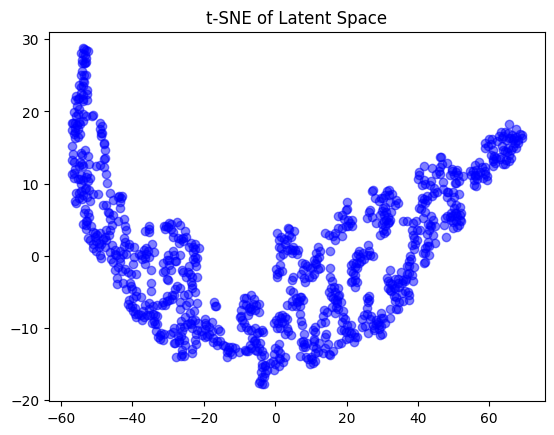

Latent space visualization with hidden layers: (10,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


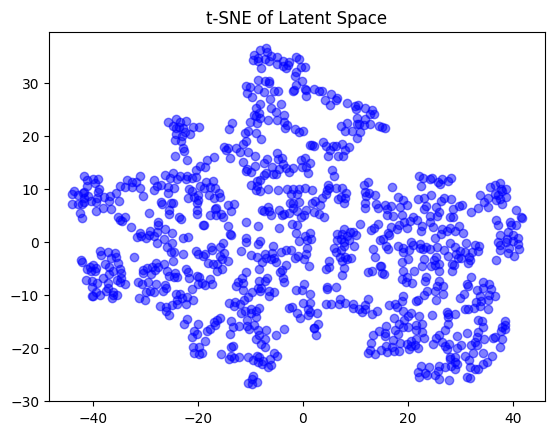

Latent space visualization with hidden layers: (20,)
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


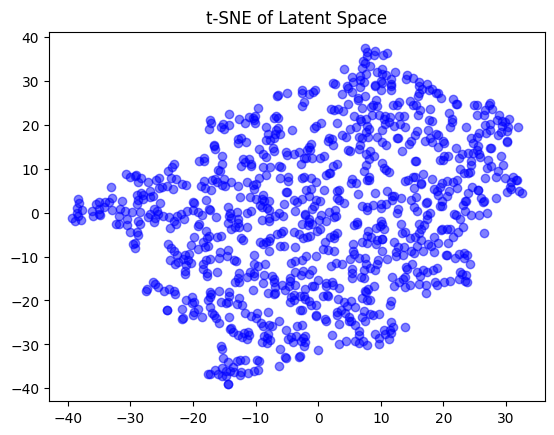

In [5]:
def visualize_latent_space(autoencoder, x_test):
    encoder = Model(autoencoder.input, autoencoder.layers[-4].output)
    encoded_imgs = encoder.predict(x_test)
    encoded_imgs = encoded_imgs.reshape((encoded_imgs.shape[0], -1))
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_imgs)

    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c='blue', alpha=0.5)
    plt.title('t-SNE of Latent Space')
    plt.show()

for hidden_layers, autoencoder in autoencoders.items():
    print(f"Latent space visualization with hidden layers: {hidden_layers}")
    visualize_latent_space(autoencoder, x_test_8)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1787 - val_loss: 0.1907
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1778 - val_loss: 0.1909
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1780 - val_loss: 0.1911
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1765 - val_loss: 0.1911
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1763 - val_loss: 0.1911
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1772 - val_loss: 0.1913
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1762 - val_loss: 0.1913
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1753 - val_loss: 0.1912
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1755 - val_loss: 0.1907
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1757 - val_loss: 0.1910
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1755 - val_loss: 0.1910
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1750 - val_lo

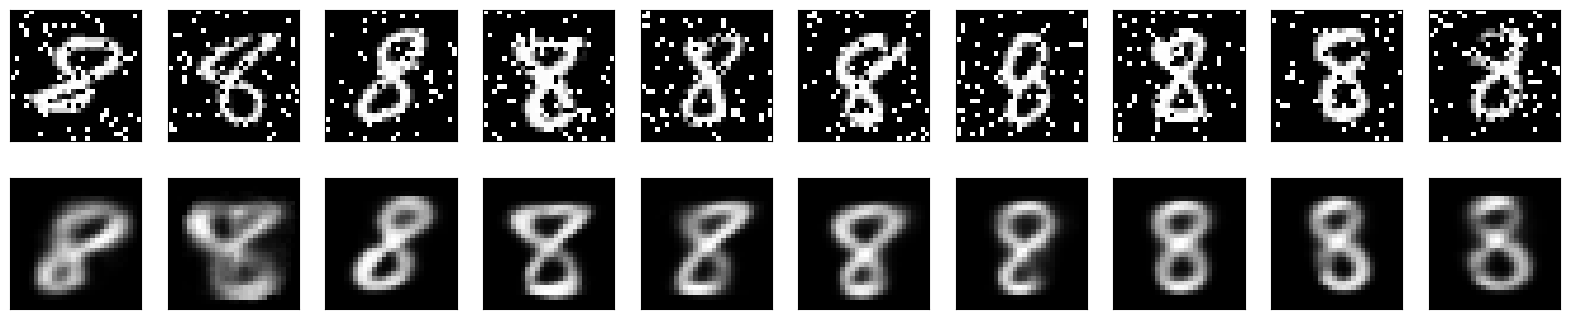

In [6]:
def add_salt_and_pepper_noise(images, amount=0.2):
    noisy_images = images.copy()
    num_salt = np.ceil(amount * images.size * 0.5)
    num_pepper = np.ceil(amount * images.size * 0.5)

    # Add Salt noise
    coords = [np.random.randint(0, i, int(num_salt)) for i in images.shape]
    noisy_images[coords[0], coords[1], coords[2]] = 1

    # Add Pepper noise
    coords = [np.random.randint(0, i, int(num_pepper)) for i in images.shape]
    noisy_images[coords[0], coords[1], coords[2]] = 0

    return noisy_images

# Apply salt and pepper noise
x_test_noisy = add_salt_and_pepper_noise(x_test_8)


autoencoder = autoencoders[(10,)]  # Using one of the trained autoencoders for denoising
autoencoder.fit(x_train_8, x_train_8, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test_8))

print("Reconstruction with noisy data:")
visualize_reconstruction(autoencoder, x_test_noisy)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


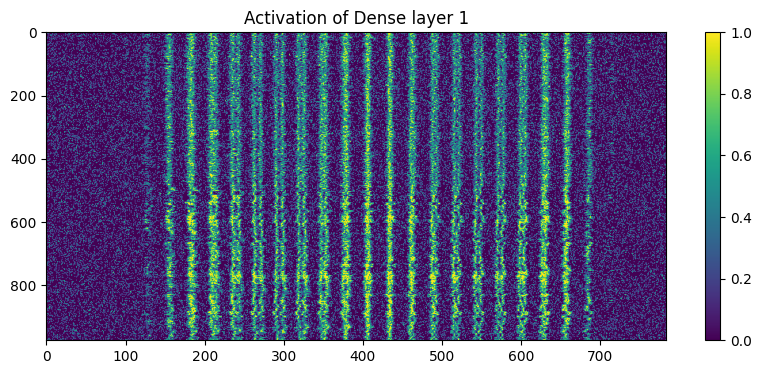

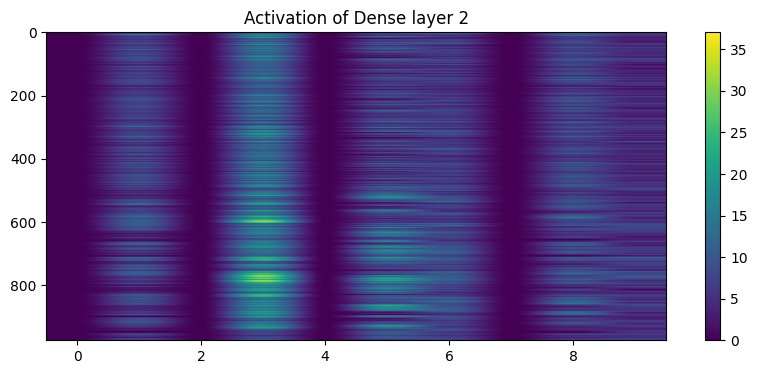

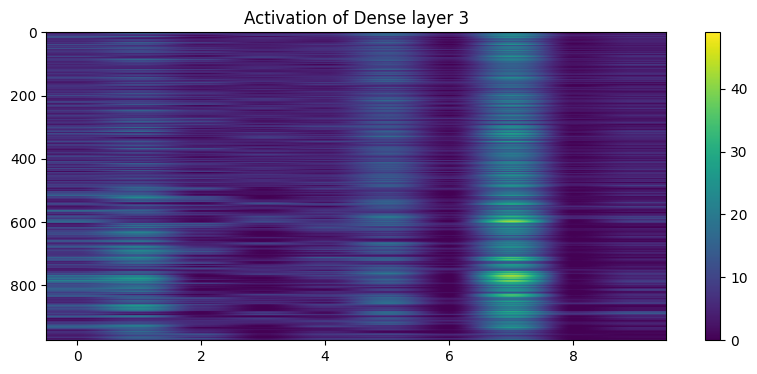

In [9]:
def visualize_intermediate_layers(autoencoder, x_test, num_layers=3):
    layer_outputs = [layer.output for layer in autoencoder.layers[1:num_layers+1]]
    activation_model = Model(inputs=autoencoder.input, outputs=layer_outputs)
    activations = activation_model.predict(x_test)

    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # For Conv2D layers
            num_filters = activation.shape[-1]
            size = activation.shape[1]
            n_cols = num_filters // 8
            plt.figure(figsize=(20, n_cols * 2))
            for j in range(num_filters):
                ax = plt.subplot(n_cols, 8, j + 1)
                plt.imshow(activation[0, :, :, j], cmap='viridis')
                plt.axis('off')
            plt.show()
        elif len(activation.shape) == 2:  # For Dense layers
            plt.figure(figsize=(10, 4))
            plt.imshow(activation, aspect='auto', cmap='viridis')
            plt.colorbar()
            plt.title(f'Activation of Dense layer {i+1}')
            plt.show()

# Use a safe number of layers to visualize (you can adjust this number)
visualize_intermediate_layers(autoencoder, x_test_noisy, num_layers=3)


# Whole dataset

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers
from sklearn.manifold import TSNE

# For reproducibility
np.random.seed(42)


In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [12]:
# Train autoencoder with different numbers of layers/nodes
autoencoders = {}
hidden_layer_configs = [[2], [10], [20]]

for hidden_layers in hidden_layer_configs:
    autoencoder = build_autoencoder(hidden_layers)
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
    autoencoders[tuple(hidden_layers)] = autoencoder

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5432 - val_loss: 0.2824
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2790 - val_loss: 0.2702
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2697 - val_loss: 0.2659
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2657 - val_loss: 0.2633
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2633 - val_loss: 0.2616
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2616 - val_loss: 0.2603
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2597 - val_loss: 0.2584
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2584 - val_loss: 0.2571
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2570 - val_loss: 0.2560
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2559 - val_loss: 0.2551
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2548 - val_loss: 0.2544
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Reconstruction with hidden layers: (2,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


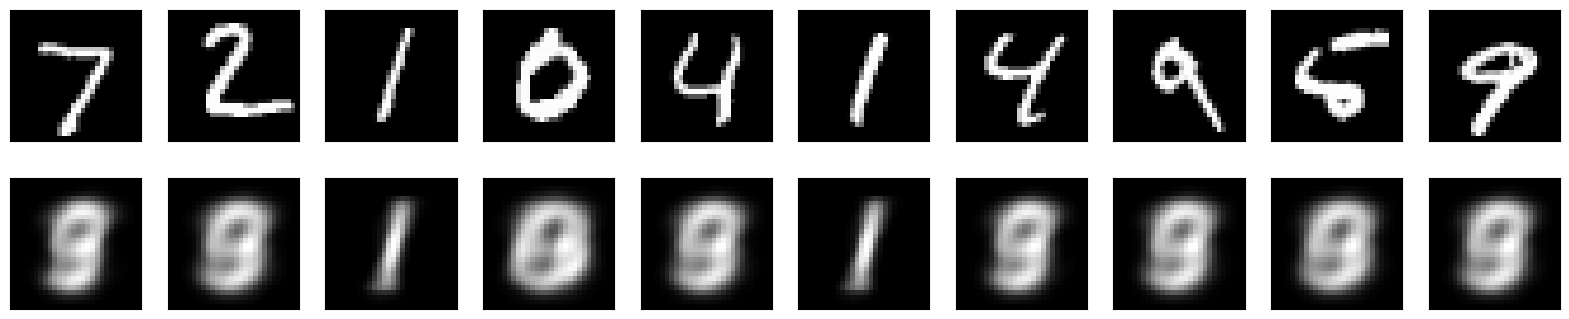

Reconstruction with hidden layers: (10,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


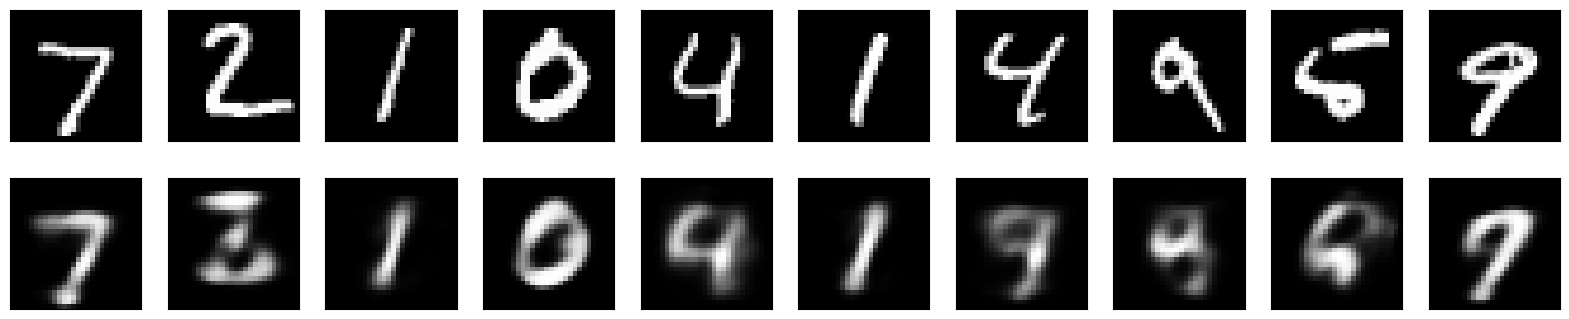

Reconstruction with hidden layers: (20,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


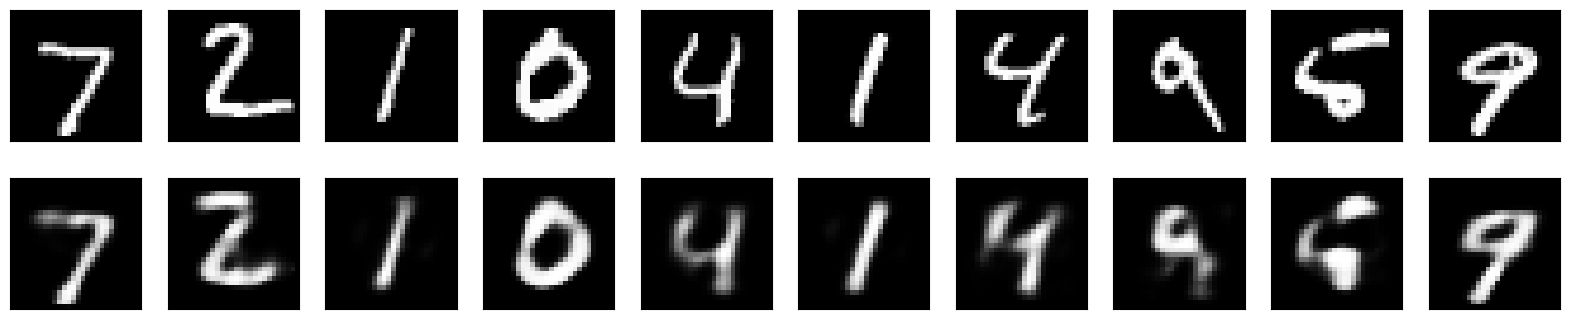

In [13]:
for hidden_layers, autoencoder in autoencoders.items():
    print(f"Reconstruction with hidden layers: {hidden_layers}")
    visualize_reconstruction(autoencoder, x_test)

Latent space visualization with hidden layers: (2,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


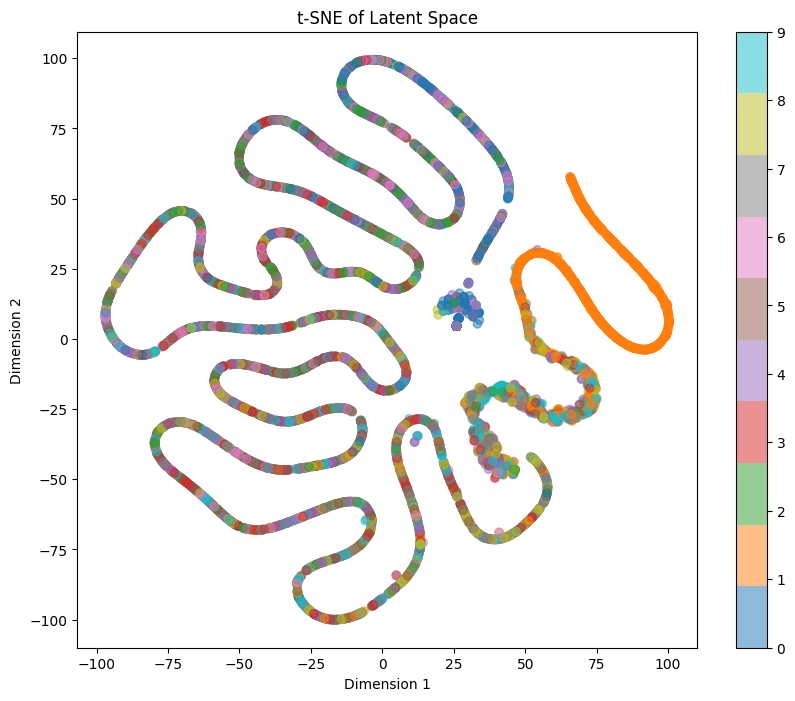

Latent space visualization with hidden layers: (10,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


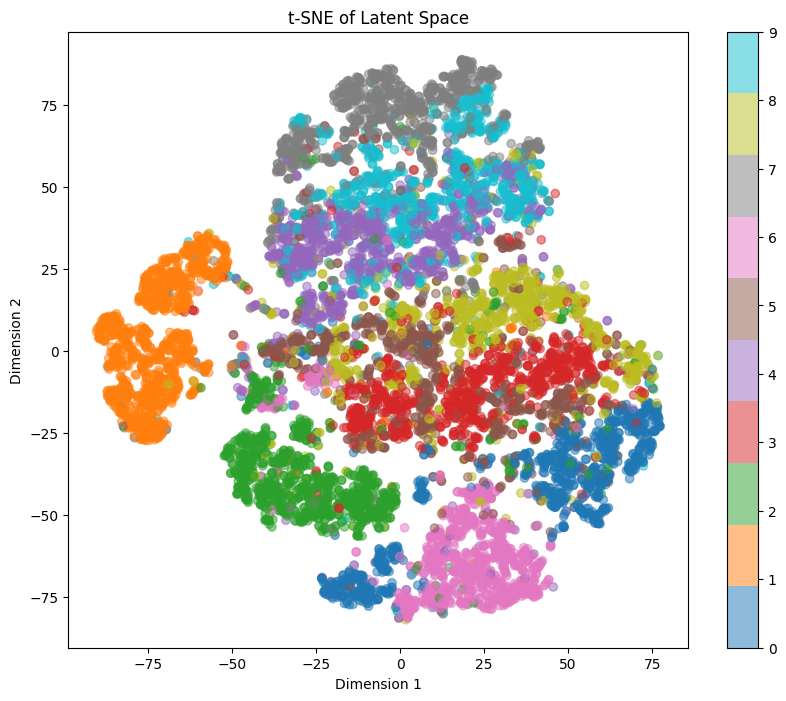

Latent space visualization with hidden layers: (20,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


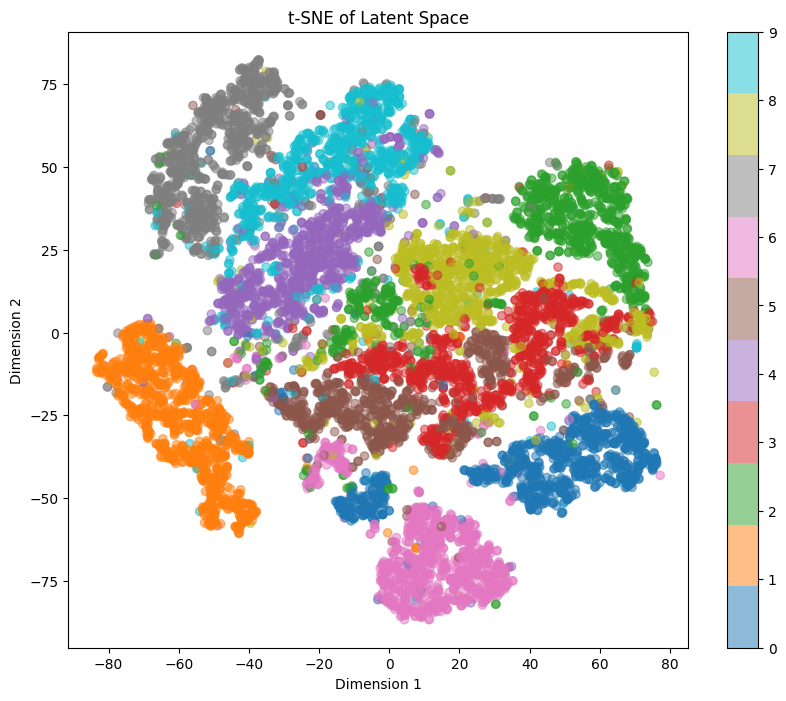

In [14]:
def visualize_latent_space(autoencoder, x_test, y_test):
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-4].output)
    encoded_imgs = encoder.predict(x_test)
    encoded_imgs = encoded_imgs.reshape((encoded_imgs.shape[0], -1))
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_imgs)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter, ticks=range(10))
    plt.title('t-SNE of Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Visualize latent space for all trained autoencoders
for hidden_layers, autoencoder in autoencoders.items():
    print(f"Latent space visualization with hidden layers: {hidden_layers}")
    visualize_latent_space(autoencoder, x_test, y_test)


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1603 - val_loss: 0.2419
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1599 - val_loss: 0.2418
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1594 - val_loss: 0.2430
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1596 - val_loss: 0.2432
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1599 - val_loss: 0.2438
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1596 - val_loss: 0.2437
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1599 - val_loss: 0.2446
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1593 - val_loss: 0.2446
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1594 - val_loss: 0.2468
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1596 - val_loss: 0.2464
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1601 - val_loss: 0.2456
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

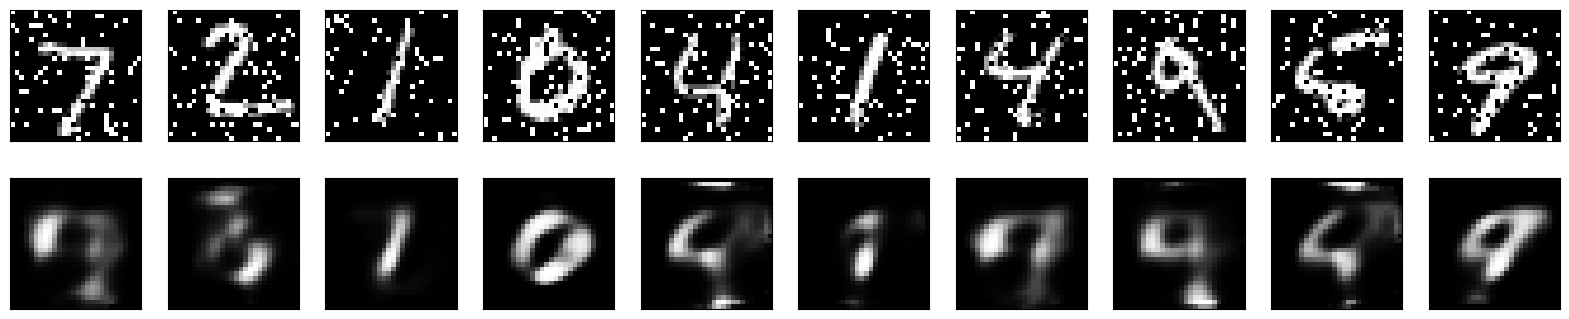

In [15]:
# Apply salt and pepper noise
x_test_noisy = add_salt_and_pepper_noise(x_test)

autoencoder = autoencoders[(10,)]  # Using one of the trained autoencoders for denoising
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test_noisy, x_test))

print("Reconstruction with noisy data:")
visualize_reconstruction(autoencoder, x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


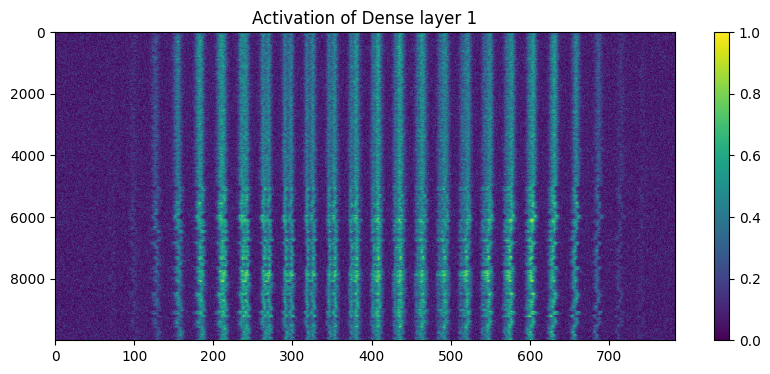

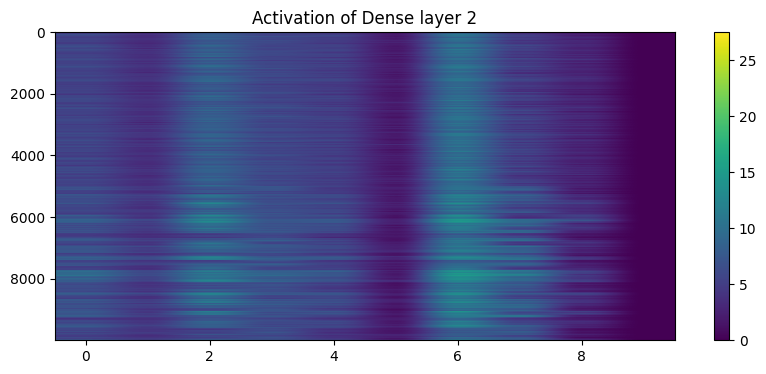

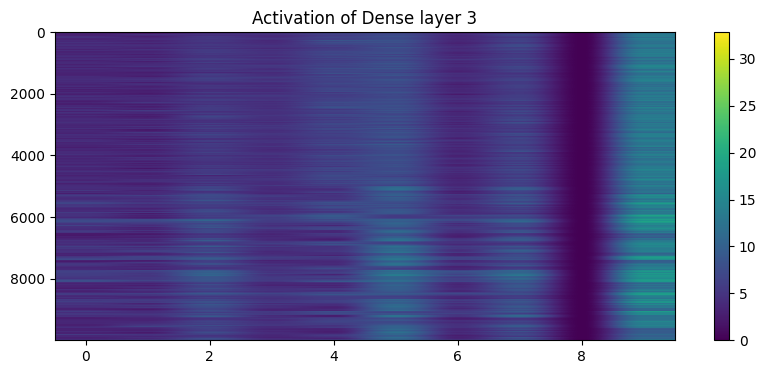

In [16]:
visualize_intermediate_layers(autoencoder, x_test_noisy, num_layers=3)

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │       100,738 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       101,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,258 (790.07 KB)

 Trainable params: 202,258 (790.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3622 - val_loss: 0.2341
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2321 - val_loss: 0.2232
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2217 - val_loss: 0.2149
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2144 - val_loss: 0.2090
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2082 - val_loss: 0.2052
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2051 - val_loss: 0.2027
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2027 - val_loss: 0.2007
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2002 - val_loss: 0.1990
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1990 - val_loss: 0.1979
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1974 - val_loss: 0.1963
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1964 - val_loss: 0.1955
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

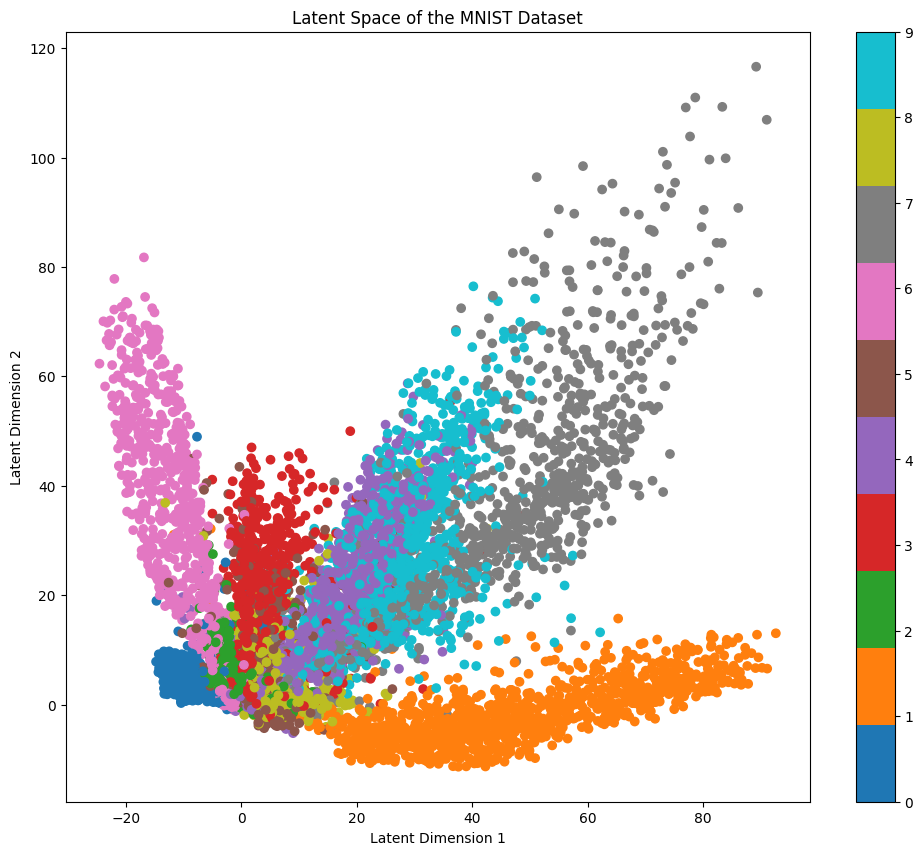

In [18]:

# Normalizing and reshaping the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Network parameters
input_shape = x_train.shape[1]
latent_dim = 2  # Dimensionality of the latent space

# Encoder model
inputs = Input(shape=(input_shape,), name='encoder_input')
x = Dense(128, activation='relu')(inputs)
z = Dense(latent_dim, name='latent_vector')(x)

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(128, activation='relu')(latent_inputs)
outputs = Dense(input_shape, activation='sigmoid')(x)

# Autoencoder model
encoder = Model(inputs, z, name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# Autoencoder configuration
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# Training the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# Display the latent space
z_test = encoder.predict(x_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space of the MNIST Dataset")
plt.show()
